# Classification of pitches

The goal here is to classify the types of pitches thrown by a given pitcher. Though the pitchfx data comes with pitch classfications, it is known to not be very reliable ("It is accurate enough for most work that involves differentiating between fastballs and off-speed pitches"--Fast, "What the heck is PitchFX?"). Additionally, clustering is a relatively simple task to perform with PitchFX and has a good chance to be able to separate pitches.

To start, we will link the relevant libraries.

In [115]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Gathering data

For our classification, we will choose one pitcher to examine. Let's choose 'Barry Zito', who we observed briefly in our EDA. He is known for the break of his curveball and a below-average fastball.

### Connecting to database

Let's specificy the database name and path, then connect to the database.

In [116]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

### Selecting pitches

We'll query our database to get all the pitches he threw in 2008.  Note that we will not worry about sorting the pitches by pitch number since we are just clustering pitches. Additionally, the *pitchfx* table does not have the pitcher id stored. Instead, we have to link the *pitchfx* table to the *events* table to get player id information. We'll print out the first five pitches.

In [293]:
query = """SELECT DISTINCT pitchfx.* 
    FROM pitchfx
    JOIN events ON (pitchfx.game_id=events.game_id
        AND pitchfx.prev_event=events.event_id)
    WHERE events.pitcher_id=(SELECT player_id
        FROM players
        WHERE players.player_first='Barry'
            AND players.player_last='Zito')
    ORDER BY game_id, pitch_num"""
bz_pfx = pd.read_sql_query(query, db)
bz_pfx.head()

,game_id,pitch_num,at_bat,time,prev_event,description,outcome,pre_balls,post_balls,pre_strike,...,vz0,ax,ay,az,break_y,break_angle,break_length,spin_dir,spin_rate,pitch_type
0,233769,30,4,134206.0,7,Ball,B,0,1,0,...,-4.167,-4.395,28.973,-13.125,23.7,16.5,3.9,192.990,2278.601,FC
1,233769,31,4,134217.0,7,Called Strike,S,1,1,0,...,-7.852,-1.776,29.654,-9.818,23.7,8.9,3.2,184.540,2620.543,FF
2,233769,32,4,134228.0,7,Foul,S,1,1,1,...,-2.479,3.593,22.606,-23.886,23.7,-8.3,9.2,156.564,1243.876,CH
3,233769,33,4,134247.0,7,"In play, no out",X,1,1,2,...,-5.803,-1.431,30.550,-8.798,23.7,12.1,2.8,183.501,2732.740,FF
4,233769,37,5,134336.0,8,Ball,B,0,1,0,...,-2.421,-3.625,31.828,-12.756,23.6,18.5,3.8,190.573,2300.700,FF


## Data cleaning

The goal here is to classify pitches ourselves, as we saw from EDA that there are some apparent pitch misclassifications (for instance, some cutters seemed to be grouped with sliders when looking at movement information).

From EDA we saw that the pitch data for Barry Zito contains a number of Nans. Fortunately, the Nans appeared to be spread out throughout data observations (such they appear somewhat random over time and are unlikely to add any bias), and they were only present in 3% of the pitches. We could choose to impute some of the missing feature information for a given observation, but from EDA we saw that where there were Nans for a given pitch, nearly all of the trajectory features were missing. Therefore, we'll drop the pitches containing any Nans rather than try to fill them in based on only situational information.

In [291]:
# number of data points before
print("number of observations including nans: ", bz_pfx.shape[0])

# drop nans
bz_pfx = bz_pfx.dropna(axis=0, how="any")

# number of data points after
print("number of observations without nans: ", bz_pfx.shape[0])

number of observations including nans:  3206
number of observations without nans:  3102


In [307]:
ind = np.where(bz_pfx.isnull())[0][0]
bz_pfx.iloc[ind, :]

game_id                  233769
pitch_num                   125
at_bat                       16
time                        NaN
prev_event                   23
description     In play, out(s)
outcome                       X
pre_balls                     0
post_balls                    0
pre_strike                    0
post_strike                   0
start_speed                 NaN
end_speed                   NaN
sz_top                      NaN
sz_bot                      NaN
pfx_x                       NaN
pfx_z                       NaN
px                          NaN
pz                          NaN
x                         85.84
y                        122.61
x0                          NaN
y0                          NaN
z0                          NaN
vx0                         NaN
vy0                         NaN
vz0                         NaN
ax                          NaN
ay                          NaN
az                          NaN
break_y                     NaN
break_an

Let's take a look at all the features we have at our disposal. We'll first get a list of all the feature names.

In [118]:
pitch_info.columns

Index(['game_id', 'pitch_num', 'at_bat', 'time', 'prev_event', 'description',
       'outcome', 'pre_balls', 'post_balls', 'pre_strike', 'post_strike',
       'start_speed', 'end_speed', 'sz_top', 'sz_bot', 'pfx_x', 'pfx_z', 'px',
       'pz', 'x', 'y', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'break_y', 'break_angle', 'break_length', 'spin_dir', 'spin_rate',
       'pitch_type'],
      dtype='object')

Decriptions of these pitch variables can be found here: https://fastballs.wordpress.com/category/pitchfx-glossary/. As we can see, we have a combination of indexing, trajectory-related, and location-related features.

Next, we'll get a printed summary of each of the data features.

In [119]:
# get data summary
pitch_info.describe().T

,count,mean,std,min,25%,50%,75%,max
game_id,3206.0,235007.269807,711.858251,233769.000,234400.00000,234994.0000,235632.00000,236137.000
pitch_num,3206.0,203.254835,122.616825,3.000,101.00000,194.0000,302.00000,522.000
at_bat,3206.0,26.173737,15.758436,1.000,13.00000,25.0000,39.00000,68.000
time,3102.0,177477.396841,28700.181873,124614.000,142823.25000,192443.0000,200936.75000,215142.000
prev_event,3206.0,33.809732,21.274918,0.000,16.00000,32.0000,50.00000,92.000
pre_balls,3206.0,0.958515,0.999451,0.000,0.00000,1.0000,2.00000,3.000
post_balls,3206.0,1.357143,1.073009,0.000,1.00000,1.0000,2.00000,4.000
pre_strike,3206.0,0.827199,0.826675,0.000,0.00000,1.0000,2.00000,3.000
post_strike,3206.0,1.177168,0.848853,0.000,1.00000,1.0000,2.00000,3.000
start_speed,3102.0,79.575113,6.089297,61.600,73.80000,82.2000,85.10000,89.400


Note that the count for each feature is not the same. Thus, there are likely to be a number of Nans in the dataset. Let's take a look at the rows containing Nans to check if they are related to games or specific pitches or random. We will also compute the fraction of data observations containing Nans.

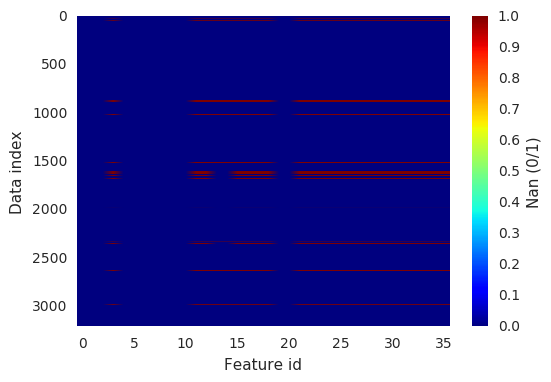

fraction of data points containing Nans:  0.032439176544


In [124]:
# view rows containing Nans
inans = pitch_info.isnull()
plt.imshow(inans,
          aspect='auto',
          cmap="jet")
plt.xlabel('Feature id')
plt.ylabel('Data index')
plt.grid(False)
plt.colorbar(label="Nan (0/1)")
plt.show()

# fraction containing Nans
print("fraction of data points containing Nans: ", np.sum(inans.any(axis=1))/len(pitch_info))

Based on the indices of the Nans in the data matrix, it seems that if a data point contains Nans, then the Nans are found across multiple features. Additionally, the rows containing Nans seem to be spread out across the data index. Therefore, it seems unlikely that there is a systematic pattern in where there are Nans.

Because only 3% of the data points contain Nans, and because there does not seem to be a systematic pattern in when the Nans occur, we will drop these pitches from the data frame rather than using imputation.

In [125]:
# drop Nans from pitch_info
pitch_info = pitch_info.dropna(axis=0, how="any")

# get shape of pitch_info
print("shape of pitch_info: ", pitch_info.shape)

shape of pitch_info:  (3102, 36)


Now that we've cleaned the data frame of Nans, we are left with 3102 pitches, which is still a large number of data points for pitch clustering, given that most pitchers have only 3-5 different pitches.

Next, we will remove features manually that we know will not affect the type of pitch thrown. The most obvious are the features that are solely used for indexing/bookkeeping, such as `game_id`, `pitch_num`, `at_bat`, `time`, and `prev_event`. We also remove any features that are strings for now (`outcome`, `description`, and `pitch_type`). Finally, we will remove situational features such as `pre_balls`, `post_balls`, `pre_strike`, `post_strike`, and stike-zone dimensions `sz_top` and `sz_bot`, as pitches can be thrown on any count to any strike zone dimension.

In [126]:
# remove bookkeeping features from data frame
pitches = pitch_info.drop(["game_id",
                          "pitch_num",
                          "at_bat",
                          "time",
                          "prev_event",
                          "description",
                          "outcome",
                          "pitch_type",
                          "pre_strike",
                          "post_strike",
                          "pre_balls",
                          "post_balls",
                          "sz_top",
                          "sz_bot"], 1)

Another way to get a quick look at our data is through a scatter matrix, which plots all scatter plots of all combinations of pairs of features. We can do that here since the number of features is relatively small. We'll plot the first 1000 pitches thrown here. (Note: this will take some time)

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=50.0, right=50.0
  'left=%s, right=%s') % (left, right))
/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=50.0, top=50.0
  'bottom=%s, top=%s') % (bottom, top))


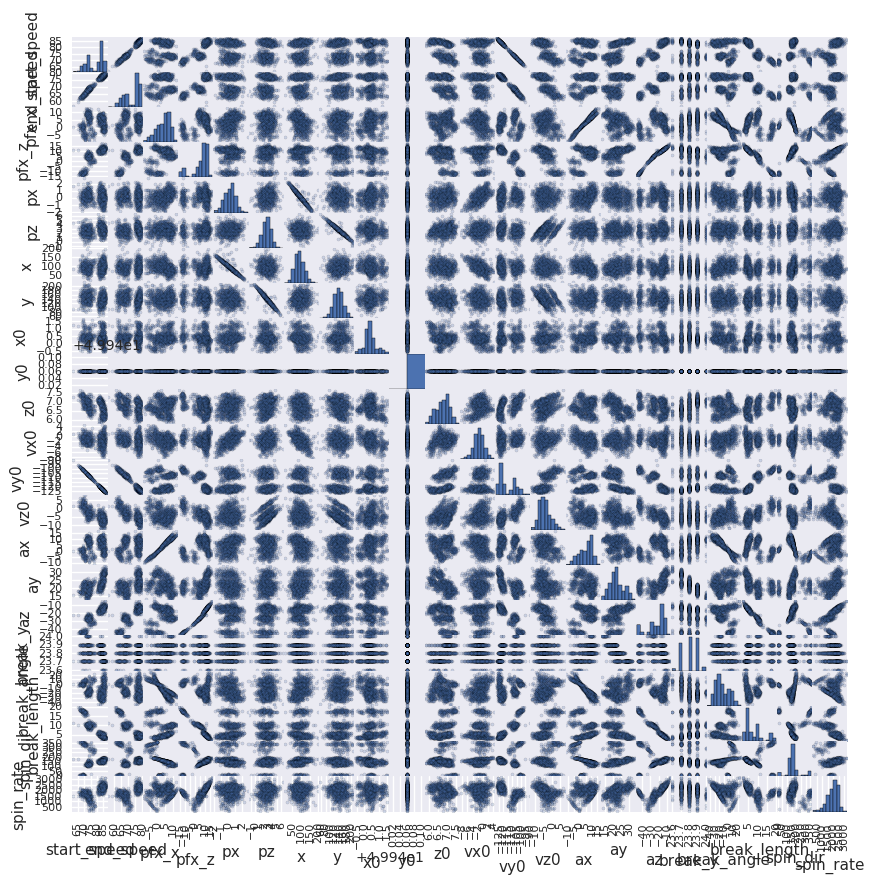

In [127]:
# create scatter matrix of numerical features
pd.scatter_matrix(pitches.iloc[:1000, :],
                  alpha=0.2,
                  figsize=(10, 10),)
plt.show()

We can note some interesting patterns in the features here. In particular, we can see clusters beginning to be drawn out of the data. For instance, have a look at `start_speed` and `pfx_x`, and `start_speed` and `pfx_z`. We can also see that `y0` (the distance in feet from home plate where the PITCHf/x system is set to measure the initial parameters) is constant for all pitches, and `break_y` has very discrete set of values. Furthermore, a number of features appear to be highly correlated, as they display strong linear patterns (e.g., `x` and `px`). Let's look at how correlated some of these features are after removing features that have discrete values.

In [128]:
# remove features with discrete values
pitches = pitches.drop(["y0",
                        "break_y"], 1)

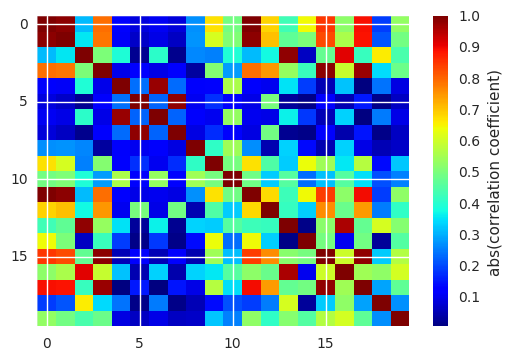

In [286]:
# visualize correlation matrix
pcorr = np.corrcoef(pitches.T)
plt.imshow(abs(pcorr),
          aspect='auto',
          cmap="jet",
          interpolation="none",)
plt.colorbar(label="abs(correlation coefficient)")
plt.show()

We can see that a number of features have very high correlation coefficients, even off of the diagonal. Let's take a closer look at the features that have (absolute values of) correlation coefficients over 0.95.

In [131]:
# find features with high correlation
hcorr =np.argwhere(np.logical_and(abs(pcorr)>0.975, pcorr!=1))

# convert indices to features
for ii in hcorr:
    print(pitches.columns[ii[0]], pitches.columns[ii[1]],)

start_speed end_speed
start_speed vy0
end_speed start_speed
end_speed vy0
pfx_x ax
pfx_z az
px x
pz y
x px
y pz
vy0 start_speed
vy0 end_speed
ax pfx_x
az pfx_z
az break_length
break_length az


We will note these correlated features when clustering.

## Clustering

### Based on features from intuition

Let's try hierarchical clustering since we do not want to assume that we know the number of clusters beforehand. All data points begin as their own cluster, in some ways. Then we fuse data points together that are similar to each other, and continue until all data points are in one cluster. There are some controls over how clusters are fused. There are five common types of linkage (complete, average, single, centroid, ward). There are also dissimilarity measures, such as Euclidean distance and correlation-based distances. For the case of pitch classification, we will start for Euclidean distance, as we're looking for feature values with similar values.

Start by importing the clustering object from scipy.

In [133]:
# import
import scipy.cluster.hierarchy as hier

Remember that we should standardize the features (mean 0, standard deviation 1) before clustering, as we do not want distances (here Euclidean) to be biased by one feature. We'll focus on just the three features from intuition (`start_speed`, `ax`, and `az`).  We'll avoid adding more features for now, as we would like to avoid the clustering problems associated with higher-dimensional data.

In [173]:
# subset of pitches
pitches_intuit = pitches[["ax",
                          "az",
                          "start_speed"]]

Now let's perform hierarchical clustering on the data. We'll use the Ward variance minimization algorithm for the linkage.

In [179]:
# generate linkage matrix
hclust_comp = hier.linkage((pitches_intuit-pitches_intuit.mean())/pitches_intuit.std(),
                           method='ward',
                           metric='euclidean')

Now let's plot the corresponding dendrogram, colored by a cutoff distance of 25.

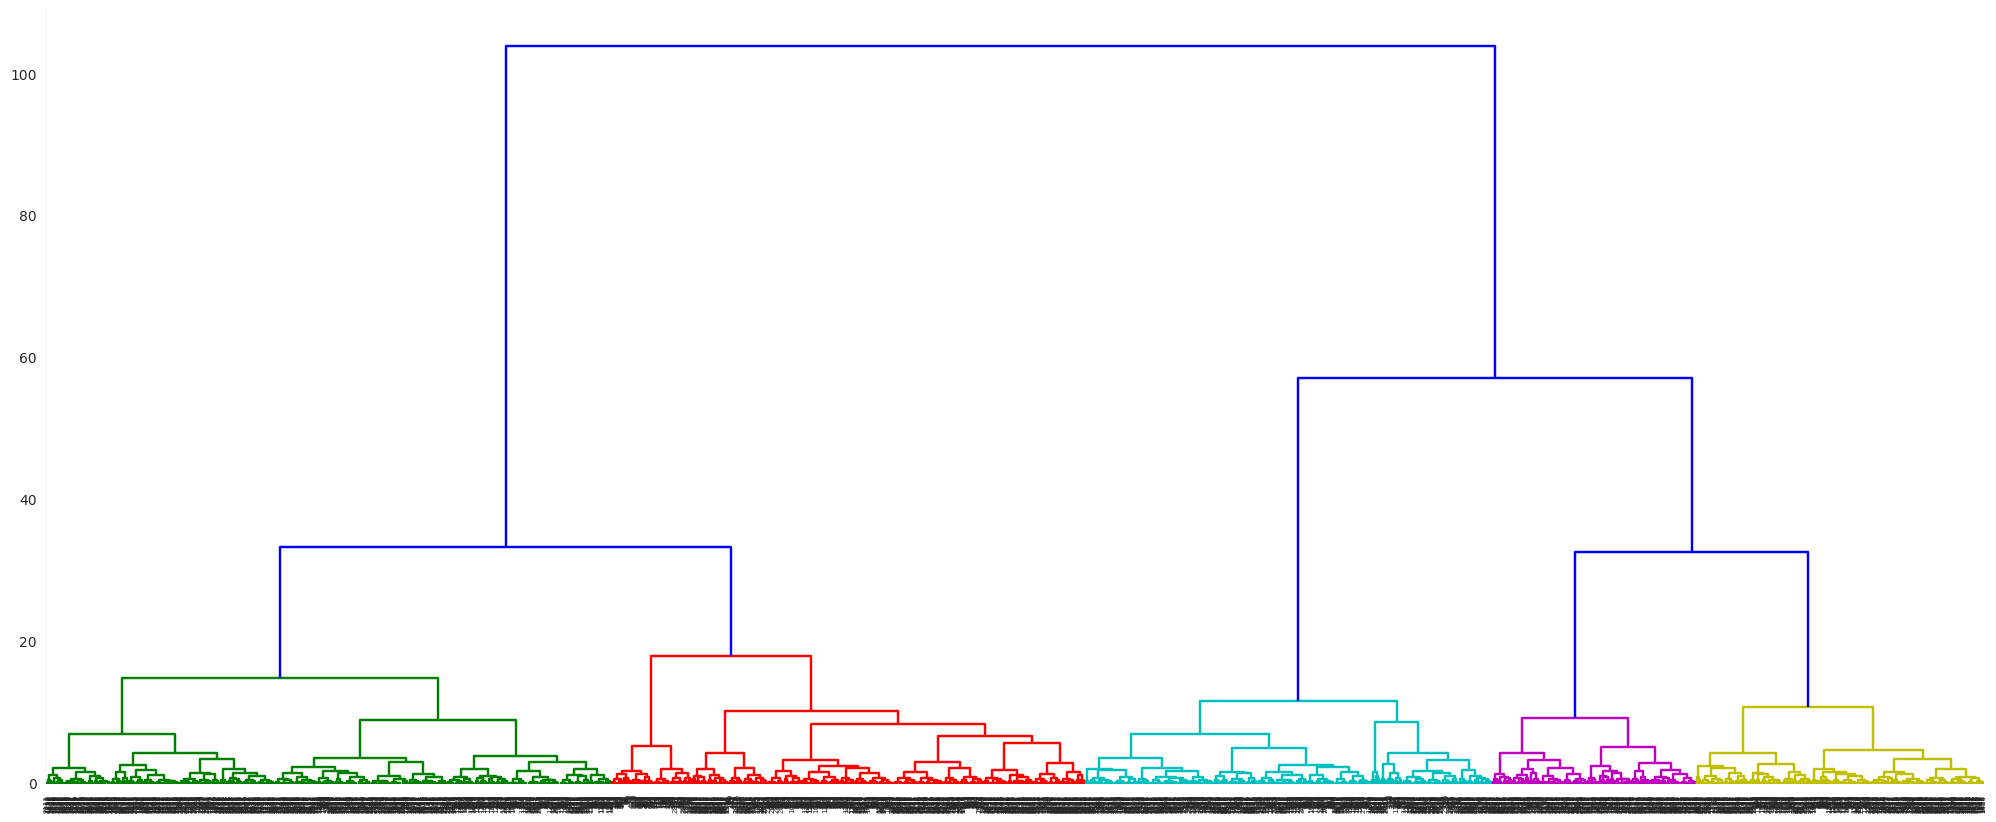

In [283]:
# plot the dendrogram colored by a certain height
hcut = 25
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_comp,
                        color_threshold=hcut,
                        leaf_rotation=90)

We see that with this clustering, we get 5 clear clusters. Let's project the cluster classification back onto our original feature axes using a crossplot function.

In [287]:
# create function for cross plots
def xplot3(dataframe3, ax0, ax1, ax2, *label):
    """Create crossplots of over three variables
    
    Input:
        dataframe3: pd dataframe
        ax0: feature string 1
        ax1: feature string 2
        ax2: feature string 3
        label: optional color label (if not specified then plots the third axis)
        
    Outputs:
        crossplots over all combinations of three features
    """
    # check if color label
    if label:
        col = [label[0] for ii in range(3)]
    else:
        col = [dataframe3[ax2], dataframe3[ax0], dataframe3[ax1]]

    # initialize subplots and feature vector
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    axes = [ax0, ax1, ax2, ax0, ax1]
    
    # loop over figures
    for ii in range(3):
        pp = ax[ii].scatter(dataframe3[axes[ii]],
                            dataframe3[axes[ii+1]],
                            c=col[ii],
                            cmap="jet",
                            alpha=0.2)
        ax[ii].set_xlabel(axes[ii])
        ax[ii].set_ylabel(axes[ii+1])
        if label:
            plt.colorbar(pp, ax=ax[ii])
        else:
            plt.colorbar(pp, ax=ax[ii], label=axes[ii+2])
    
    plt.show()
    
    # clean up
    return

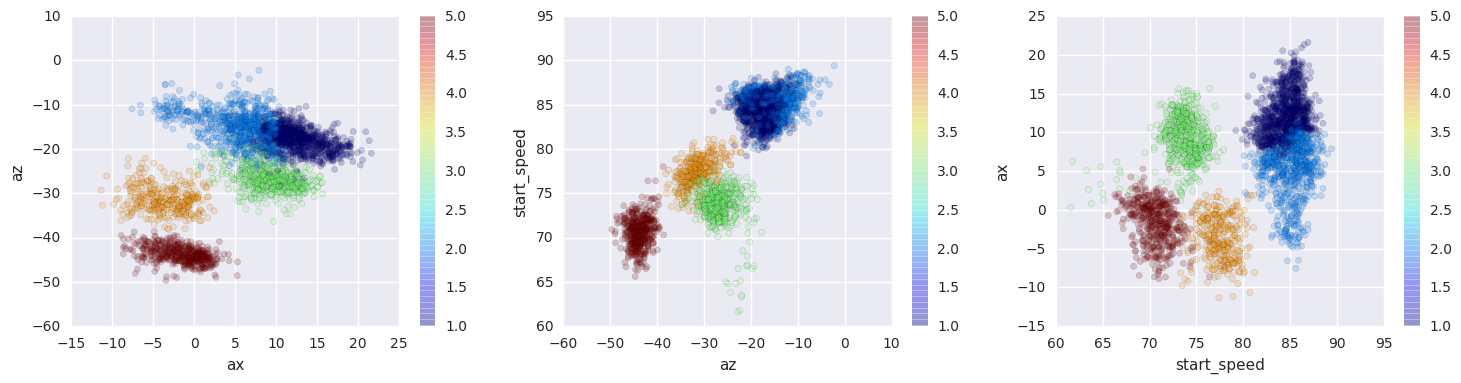

In [275]:
# labels
hlabel = hier.fcluster(hclust_comp, hcut, 'distance')

# plot
xplot3(pitches, "ax", "az", "start_speed", hlabel)

We can see that we the clusters look reasonable. Interestingly, the large cluster at the highest velocities got broken into two. Based on the feature values associated with each of these clusters, the light blue group is likely his four-seam fastball, the dark blue cluster is likely his two-seam fastball (which tails from left to right), the green cluster is likely his changeup, the orange cluster is likely his slider, and his red cluster is likely his notorious curveball.

These pitch classification descriptions are based on the pitch chart in https://www.fangraphs.com/library/pitch-type-abbreviations-classifications/ (flip for left-handed pitchers).

Let's take a look at the pitch classifications from our database.

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


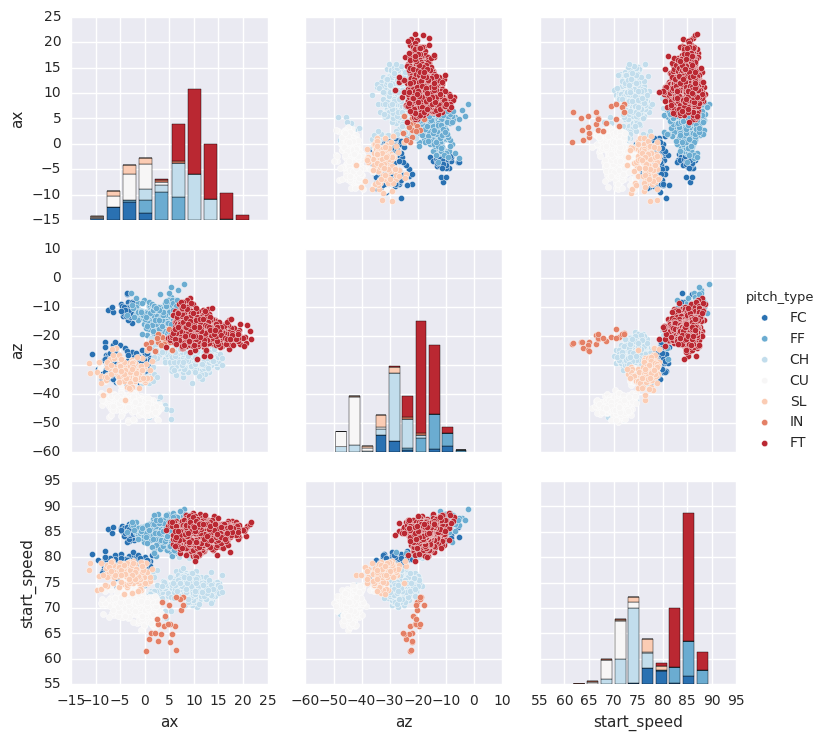

In [171]:
## pitch type from database
#pclass = pitch_info["pitch_type"].astype('category').cat.codes
#
## project label onto data points
#plt.scatter(pitches["ax"], 
#            pitches["start_speed"], 
#            c=pclass, 
#            cmap="jet",
#            alpha=0.5)
#plt.xlabel("Horizontal acceleration (ft/s2)")
#plt.ylabel("Start speed (mph)")
#plt.show()

# pitch type from database
pitches_intuit["pitch_type"] = pitch_info["pitch_type"]
sns.pairplot(data=pitches_intuit,
             hue="pitch_type",
             palette="RdBu_r")
plt.show()

As we can see, the pitch classifications here are very different from our pitch classification. Looking at `ax` vs `start_speed`, we can see that the cutter (blue) is found in both the primary clusters for the four-seamer (green-blue) and the slider (pink). While it is possible that the cutter does exist, it is difficult to believe that it is also that similar to his slider. Therefore, it looks like our clustering algorithm might be doing a better job than what was provided by PitchFX, although with one fewer pitch type.

Let's actually go back and pull out the sixth cluster from our hierarchical clustering and see what we get.

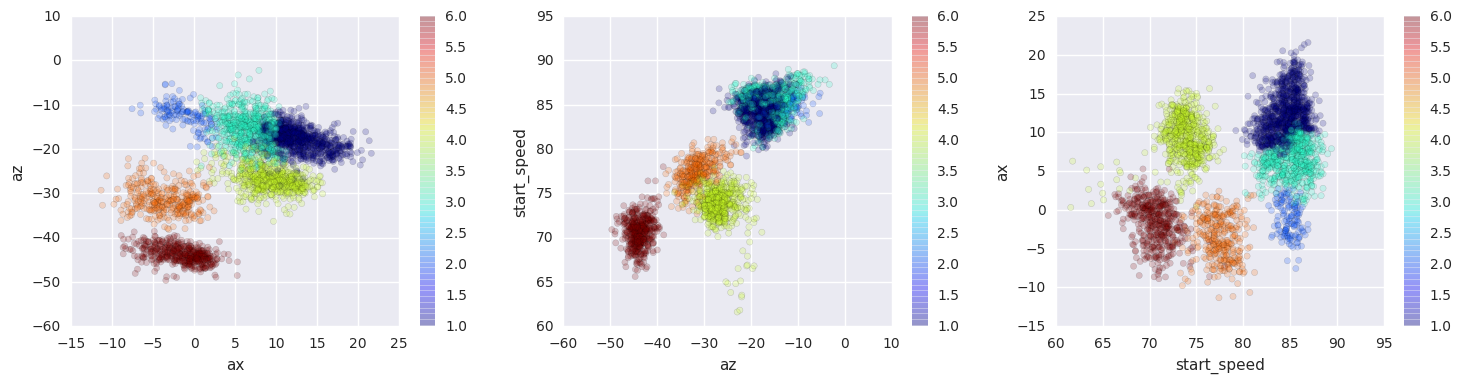

In [276]:
# labels
hcut = 18
hlabel = hier.fcluster(hclust_comp, hcut, 'distance')

# plot
xplot3(pitches, "ax", "az", "start_speed", hlabel)

With six clusters, we actually see the probable cutter being separated. It has similar horizontal acceleration as the slider and curveballs, but has velocity comparable to his two other fastballs.

Let's see what happens when we go to seven clusters.

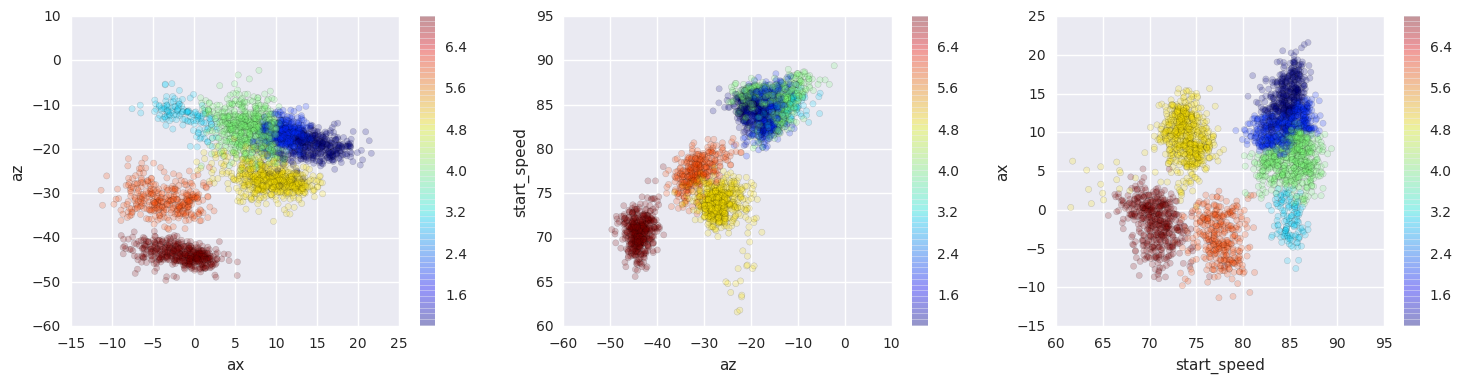

In [282]:
# labels
hcut = 13
hlabel = hier.fcluster(hclust_comp, hcut, 'distance')

# plot
xplot3(pitches, "ax", "az", "start_speed", hlabel)

With seven clusters, we see that the fastball cluster is divided into four clusters. Therefore, the two additional clusters are just finding variations of the fastball. We will go with six total clusters for now, which describe the four-seamer, two-seamer, cutter, changeup, slider, and curveball. Overall, it seems like we can do a better job of classifying pitches than with the labels given.

## to do

1) pca with dbscan using all features

2) create eda notebook